# Image classifier project

## Configure notebook

In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Import modules

In [16]:
import time

import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models, utils

## Configure torch device

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Configure the locations of the source data

In [18]:
data_dir = 'flowers'
training_data_dir = data_dir + '/train'
validation_data_dir = data_dir + '/valid'
testing_data_dir = data_dir + '/test'

## Define transforms, datasets and dataloaders

In [19]:
# Define transforms for the training, validation, and testing sets
normalised_transform = transforms.Normalize([0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])

training_transforms = transforms.Compose([transforms.RandomRotation(30),
                                          transforms.RandomResizedCrop(224),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          normalised_transform])

validation_transforms = transforms.Compose([transforms.Resize(255),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            normalised_transform])

testing_transforms = transforms.Compose([transforms.Resize(255),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            normalised_transform])

# Load the datasets with ImageFolder
training_dataset = datasets.ImageFolder(training_data_dir, 
                                        transform=training_transforms)
validation_dataset = datasets.ImageFolder(validation_data_dir, 
                                          transform=validation_transforms)
testing_dataset = datasets.ImageFolder(testing_data_dir, 
                                       transform=testing_transforms)

# Define the dataloaders using the image datasets and trainforms
training_dataloader = torch.utils.data.DataLoader(training_dataset, 
                                                  batch_size=64, 
                                                  shuffle=True,
                                                  pin_memory=True)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset,
                                                    batch_size=64,
                                                    shuffle=True,
                                                    pin_memory=True)
testing_dataloader = torch.utils.data.DataLoader(testing_dataset,
                                                 batch_size=64,
                                                 shuffle=True,
                                                 pin_memory=True)

In [20]:
import json

with open('cat_to_name.json', 'r') as file:
    cat_to_name = json.load(file)

len(cat_to_name)

102

## Define the model

In [21]:
model = models.densenet121(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 102),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device);

## Train the model

In [22]:
epochs = 10
steps = 0

training_losses, validation_losses = [], []
for e in range(epochs):

    start_time = time.time()
    
    total_training_loss = 0
    model.train()
    for images, expected_results in training_dataloader:
        images, expected_results = images.to(device), expected_results.to(device)
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, expected_results)
        total_training_loss += loss.item()

        loss.backward()
        optimizer.step()
        
    total_validation_loss = 0
    total_correctly_predicted = 0
    model.eval()
    with torch.no_grad():
        for images, expected_results in validation_dataloader:
            images, expected_results = images.to(device), expected_results.to(device)
            log_ps = model(images)
            loss = criterion(log_ps, expected_results)
            total_validation_loss += loss.item()

            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            correct_predictions = top_class == expected_results.view(*top_class.shape)
            total_correctly_predicted += correct_predictions.sum().item()
    
    mean_training_loss = total_training_loss / len(training_dataloader.dataset)
    mean_validation_loss = total_validation_loss / len(validation_dataloader.dataset)
    mean_correctly_predicted = total_correctly_predicted / len(validation_dataloader.dataset)

    training_losses.append(mean_training_loss)
    validation_losses.append(mean_validation_loss)

    duration = time.time() - start_time

    print("Epoch: {}/{}.. ".format(e+1, epochs),
          "Training Loss: {:.5f}.. ".format(mean_training_loss),
          "Validation Loss: {:.5f}.. ".format(mean_validation_loss),
          "Accuracy: {:.3f}.. ".format(mean_correctly_predicted),
          "Duration: {:.1f}s".format(duration))

Epoch: 1/10..  Training Loss: 0.04702..  Validation Loss: 0.02010..  Accuracy: 0.703..  Duration: 54.0s
Epoch: 2/10..  Training Loss: 0.02126..  Validation Loss: 0.01050..  Accuracy: 0.839..  Duration: 54.5s
Epoch: 3/10..  Training Loss: 0.01555..  Validation Loss: 0.00749..  Accuracy: 0.881..  Duration: 54.3s
Epoch: 4/10..  Training Loss: 0.01377..  Validation Loss: 0.00679..  Accuracy: 0.877..  Duration: 53.7s
Epoch: 5/10..  Training Loss: 0.01212..  Validation Loss: 0.00554..  Accuracy: 0.903..  Duration: 53.8s
Epoch: 6/10..  Training Loss: 0.01180..  Validation Loss: 0.00629..  Accuracy: 0.891..  Duration: 53.7s
Epoch: 7/10..  Training Loss: 0.01115..  Validation Loss: 0.00527..  Accuracy: 0.919..  Duration: 53.8s
Epoch: 8/10..  Training Loss: 0.01046..  Validation Loss: 0.00496..  Accuracy: 0.927..  Duration: 53.8s
Epoch: 9/10..  Training Loss: 0.01014..  Validation Loss: 0.00536..  Accuracy: 0.923..  Duration: 53.6s
Epoch: 10/10..  Training Loss: 0.01007..  Validation Loss: 0.005

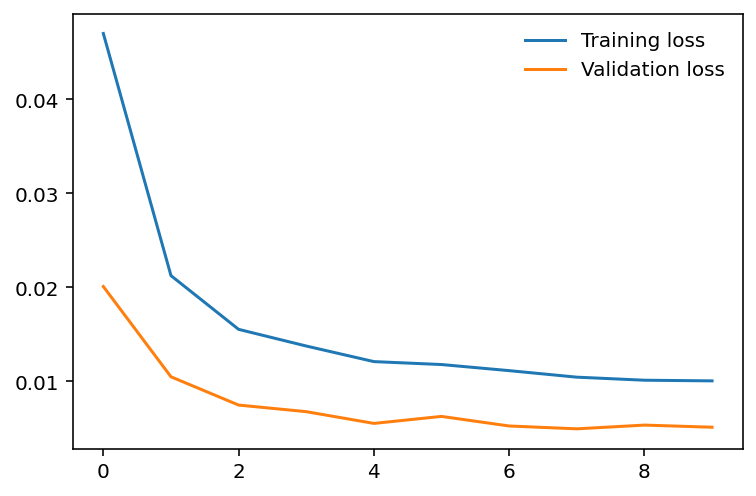

In [23]:
plt.plot(training_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.legend(frameon=False);

## Test the model

In [24]:
def view_image_prediction(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 224, 224).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(102))
    ax2.set_yticklabels(np.arange(102))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

In [25]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [26]:
def visualize_model(model, dataloader, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                #print(cat_to_name[str(preds[j].item() + 1)])
                ax.set_title('predicted: {}, actual: {}'.format(cat_to_name[str(preds[j].item() + 1)],
                                                                cat_to_name[str(labels[j].item() + 1)]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

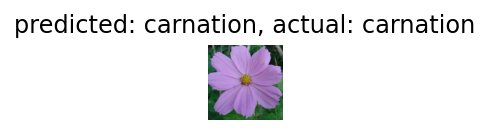

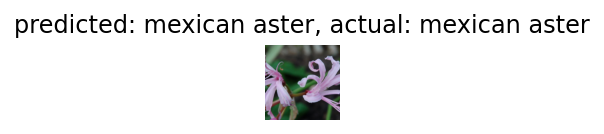

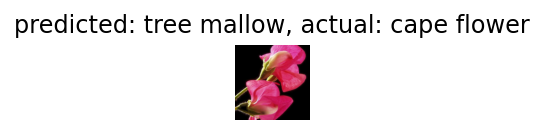

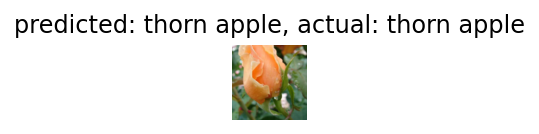

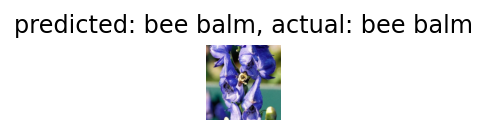

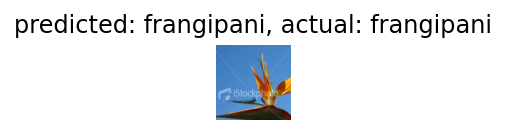

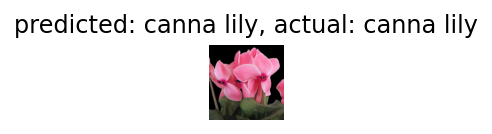

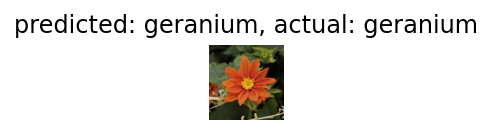

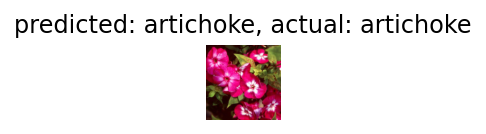

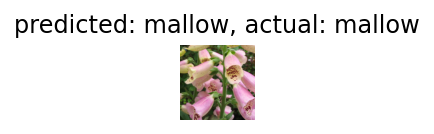

In [32]:
model.to(device)
visualize_model(model, testing_dataloader, num_images=10)